In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from itertools import permutations
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform, cosine

In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy
from surprise import SVD, SVDpp, SlopeOne, NMF, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, NormalPredictor, CoClustering

In [ ]:
users = pd.read_csv('users.csv', index_col=0)
restaurants = pd.read_csv('restaurants.csv', index_col=0)
ratings = pd.read_csv('ratings.csv', index_col=0)

In [ ]:
users.head()

,userID,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,age,interest,personality,religion,activity,weight,budget,height
0,U1001,False,abstemious,informal,family,on foot,single,independent,32,variety,thrifty-protector,none,student,152.11878,medium,5.807087
1,U1002,False,abstemious,informal,family,public,single,independent,31,technology,hunter-ostentatious,Catholic,student,88.18480,low,6.135171
2,U1003,False,social drinker,formal,family,public,single,independent,32,none,hard-worker,Catholic,student,132.27720,low,5.544620
3,U1004,False,abstemious,informal,family,public,single,independent,81,variety,hard-worker,none,professional,97.00328,medium,5.019685
21,U1005,False,abstemious,no preference,family,public,single,independent,29,none,thrifty-protector,Catholic,student,143.30030,medium,5.544620


In [ ]:
restaurants.head()

,placeID,cuisine,rest_name,city,alcohol,smoking_area,dress_code,accessibility,price,ambience,franchise,parking_lot,payment
0,135109,Italian,Paniroles,Cuernavaca,Wine-Beer,not permitted,informal,no_accessibility,medium,quiet,f,none,cash
1,135106,Mexican,El Rinc�n de San Francisco,San Luis Potosi,Wine-Beer,only at bar,informal,partially,medium,familiar,f,none,cash
2,135106,Mexican,El Rinc�n de San Francisco,San Luis Potosi,Wine-Beer,only at bar,informal,partially,medium,familiar,f,none,VISA
3,135106,Mexican,El Rinc�n de San Francisco,San Luis Potosi,Wine-Beer,only at bar,informal,partially,medium,familiar,f,none,MasterCard-Eurocard
4,135104,Mexican,vips,Ciudad Victoria,Full_Bar,not permitted,informal,completely,medium,familiar,t,yes,cash


In [ ]:
ratings.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


Finding the top Restaurants

In [ ]:
#Simple Recommender

In [ ]:
ratings_agg = ratings.groupby('placeID').agg({'userID':'count', 'rating':'mean', 'food_rating':'mean', 'service_rating':'mean'})
ratings_agg

,userID,rating,food_rating,service_rating
placeID,,,,
132560,4,0.500000,1.000000,0.250000
132561,4,0.750000,1.000000,1.000000
132564,4,1.250000,1.250000,1.500000
132572,15,1.000000,1.000000,0.933333
132583,4,1.000000,1.000000,1.250000
...,...,...,...,...
135088,6,1.000000,1.166667,1.000000
135104,7,0.857143,1.428571,0.857143
135106,10,1.200000,1.200000,1.200000


In [ ]:
ratings_agg.rename(columns={'userID':'rating_count'}, inplace=True)

In [ ]:
#mean of rating average
C = ratings_agg['rating'].mean()
C

1.179621558494296

In [ ]:
#suggestions must be as good as or better than 50% of the other listings
m = ratings_agg['rating'].quantile(.5)
m

1.1818181818181819

In [ ]:
q_rest = ratings_agg.copy().loc[ratings_agg['rating']>= m]
q_rest.shape

(66, 4)

In [ ]:
def weighted_rating(x, m=m, C=C):
  v = x['rating_count']
  R = x['rating']
  return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
q_rest['score'] = q_rest.apply(weighted_rating, axis=1)

In [ ]:
q_rest = q_rest.sort_values('score', ascending=False)
q_rest.head()

,rating_count,rating,food_rating,service_rating,score
placeID,,,,,
134986,8,2.000000,2.0,2.000000,1.894407
132955,5,2.000000,1.8,1.800000,1.843163
135034,5,2.000000,2.0,1.600000,1.843163
132922,6,1.833333,1.5,1.833333,1.725761
132755,5,1.800000,2.0,1.600000,1.681398


In [ ]:
top_rest = q_rest.merge(restaurants, how='inner', on='placeID')

In [ ]:
top_rest = top_rest.drop(columns='payment', axis=1).drop_duplicates(keep="first").sort_values('score', ascending=False)
top_rest.head()

,placeID,rating_count,rating,food_rating,service_rating,score,cuisine,rest_name,city,alcohol,smoking_area,dress_code,accessibility,price,ambience,franchise,parking_lot
0,132955,5,2.000000,1.800000,1.800000,1.843163,Bar_Pub_Brewery,emilianos,San Luis Potosi,Wine-Beer,none,informal,completely,low,familiar,t,none
5,135034,5,2.000000,2.000000,1.600000,1.843163,Japanese,Michiko Restaurant Japones,San Luis Potosi,No_Alcohol_Served,none,informal,no_accessibility,medium,familiar,f,none
9,132922,6,1.833333,1.500000,1.833333,1.725761,Cafeteria,cafe punta del cielo,San Luis Potosi,No_Alcohol_Served,permitted,formal,completely,medium,familiar,f,none
10,132755,5,1.800000,2.000000,1.600000,1.681398,Mexican,La Estrella de Dimas,San Luis Potosi,No_Alcohol_Served,none,informal,partially,medium,familiar,f,public
14,135075,13,1.692308,1.692308,1.461538,1.649584,Seafood,Mariscos El Pescador,San Luis Potosi,No_Alcohol_Served,none,informal,no_accessibility,medium,familiar,f,yes


In [ ]:
#To find best restaurant in Cuernavaca for example:
top_rest.loc[top_rest['city']=='Cuernavaca'].sort_values('score', ascending=False)

,placeID,rating_count,rating,food_rating,service_rating,score,cuisine,rest_name,city,alcohol,smoking_area,dress_code,accessibility,price,ambience,franchise,parking_lot
23,134976,4,1.750000,1.750000,1.000000,1.619914,Mexican,Log Yin,Cuernavaca,No_Alcohol_Served,none,informal,no_accessibility,low,familiar,f,yes
27,134976,4,1.750000,1.750000,1.000000,1.619914,Mediterranean,Log Yin,Cuernavaca,No_Alcohol_Served,none,informal,no_accessibility,low,familiar,f,yes
31,134976,4,1.750000,1.750000,1.000000,1.619914,Burgers,Log Yin,Cuernavaca,No_Alcohol_Served,none,informal,no_accessibility,low,familiar,f,yes
44,132768,10,1.600000,1.700000,1.400000,1.555570,Family,Mariscos Tia Licha,Cuernavaca,No_Alcohol_Served,not permitted,casual,partially,medium,familiar,t,none
63,135018,4,1.500000,1.750000,1.500000,1.426931,Mexican,El Oceano Dorado,Cuernavaca,Full_Bar,permitted,informal,completely,medium,familiar,f,yes
68,132773,4,1.500000,1.250000,1.750000,1.426931,Family,El cotorreo,Cuernavaca,Wine-Beer,permitted,informal,no_accessibility,low,familiar,f,none
69,132773,4,1.500000,1.250000,1.750000,1.426931,Mexican,El cotorreo,Cuernavaca,Wine-Beer,permitted,informal,no_accessibility,low,familiar,f,none
88,135021,9,1.333333,1.111111,0.666667,1.315492,Fast_Food,Subway,Cuernavaca,No_Alcohol_Served,not permitted,informal,no_accessibility,low,familiar,t,public


In [ ]:
#To find best restaurant in Cuernavaca for example:
top_rest.loc[top_rest['city']=='Cuernavaca'].loc[top_rest['cuisine']=='Mexican'].sort_values('score', ascending=False)

,placeID,rating_count,rating,food_rating,service_rating,score,cuisine,rest_name,city,alcohol,smoking_area,dress_code,accessibility,price,ambience,franchise,parking_lot
23,134976,4,1.75,1.75,1.00,1.619914,Mexican,Log Yin,Cuernavaca,No_Alcohol_Served,none,informal,no_accessibility,low,familiar,f,yes
63,135018,4,1.50,1.75,1.50,1.426931,Mexican,El Oceano Dorado,Cuernavaca,Full_Bar,permitted,informal,completely,medium,familiar,f,yes
69,132773,4,1.50,1.25,1.75,1.426931,Mexican,El cotorreo,Cuernavaca,Wine-Beer,permitted,informal,no_accessibility,low,familiar,f,none


In [ ]:
#To find best restaurants that are quiet and have full accessibility for example:
top_rest.loc[top_rest['ambience']=='quiet'].loc[top_rest['accessibility']=='completely'].sort_values('score', ascending=False)

,placeID,rating_count,rating,food_rating,service_rating,score,cuisine,rest_name,city,alcohol,smoking_area,dress_code,accessibility,price,ambience,franchise,parking_lot
39,132958,6,1.666667,1.500000,1.500000,1.586520,American,tacos los volcanes,San Luis Potosi,No_Alcohol_Served,none,informal,completely,low,quiet,t,none
67,132937,4,1.500000,1.000000,1.000000,1.426931,Bar,rockabilly,San Luis Potosi,Full_Bar,section,informal,completely,low,quiet,f,none
122,132921,17,1.235294,1.117647,0.882353,1.231675,Bar,crudalia,San Luis Potosi,Wine-Beer,section,casual,completely,low,quiet,f,none


Content-Based Recommending

In [ ]:
restaurants.columns

Index(['placeID', 'cuisine', 'rest_name', 'city', 'alcohol', 'smoking_area',
       'dress_code', 'accessibility', 'price', 'ambience', 'franchise',
       'parking_lot', 'payment'],
      dtype='object')

In [ ]:
restaurants.shape

(231, 13)

In [ ]:
df_r = pd.get_dummies(restaurants)

In [ ]:
df_r.head()

,placeID,cuisine_American,cuisine_Armenian,cuisine_Bakery,cuisine_Bar,cuisine_Bar_Pub_Brewery,cuisine_Breakfast-Brunch,cuisine_Burgers,cuisine_Cafe-Coffee_Shop,cuisine_Cafeteria,cuisine_Chinese,cuisine_Contemporary,cuisine_Family,cuisine_Fast_Food,cuisine_Game,cuisine_International,cuisine_Italian,cuisine_Japanese,cuisine_Mediterranean,cuisine_Mexican,cuisine_Pizzeria,cuisine_Regional,cuisine_Seafood,cuisine_Vietnamese,rest_name_Abondance Restaurante Bar,rest_name_Cabana Huasteca,rest_name_Cafe Chaires,rest_name_Cafeteria cenidet,rest_name_Cafeteria y Restaurant El Pacifico,rest_name_Carls Jr,rest_name_Carreton de Flautas y Migadas,rest_name_Cenaduria El Rincón de Tlaquepaque,rest_name_Chaires,rest_name_Dominos Pizza,rest_name_El Herradero Restaurante and Bar,rest_name_El Mundo de la Pasta,rest_name_El Oceano Dorado,rest_name_El Rincon de San Francisco,rest_name_El Rinc�n de San Francisco,rest_name_El cotorreo,...,rest_name_tacos los volcanes,rest_name_tortas hawai,rest_name_vips,city_Ciudad Victoria,city_Cuernavaca,city_Jiutepec,city_San Luis Potosi,city_Soledad,alcohol_Full_Bar,alcohol_No_Alcohol_Served,alcohol_Wine-Beer,smoking_area_none,smoking_area_not permitted,smoking_area_only at bar,smoking_area_permitted,smoking_area_section,dress_code_casual,dress_code_formal,dress_code_informal,accessibility_completely,accessibility_no_accessibility,accessibility_partially,price_high,price_low,price_medium,ambience_familiar,ambience_quiet,franchise_f,franchise_t,parking_lot_none,parking_lot_public,parking_lot_valet parking,parking_lot_yes,payment_American_Express,payment_Carte_Blanche,payment_MasterCard-Eurocard,payment_VISA,payment_bank_debit_cards,payment_cash,payment_checks
0,135109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0
1,135106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2,135106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
3,135106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0
4,135104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
df_r.placeID.duplicated().value_counts()

True     144
False     87
Name: placeID, dtype: int64

In [ ]:
df_r = df_r.groupby('placeID').sum().reset_index()

In [ ]:
df_r.head()

,placeID,cuisine_American,cuisine_Armenian,cuisine_Bakery,cuisine_Bar,cuisine_Bar_Pub_Brewery,cuisine_Breakfast-Brunch,cuisine_Burgers,cuisine_Cafe-Coffee_Shop,cuisine_Cafeteria,cuisine_Chinese,cuisine_Contemporary,cuisine_Family,cuisine_Fast_Food,cuisine_Game,cuisine_International,cuisine_Italian,cuisine_Japanese,cuisine_Mediterranean,cuisine_Mexican,cuisine_Pizzeria,cuisine_Regional,cuisine_Seafood,cuisine_Vietnamese,rest_name_Abondance Restaurante Bar,rest_name_Cabana Huasteca,rest_name_Cafe Chaires,rest_name_Cafeteria cenidet,rest_name_Cafeteria y Restaurant El Pacifico,rest_name_Carls Jr,rest_name_Carreton de Flautas y Migadas,rest_name_Cenaduria El Rincón de Tlaquepaque,rest_name_Chaires,rest_name_Dominos Pizza,rest_name_El Herradero Restaurante and Bar,rest_name_El Mundo de la Pasta,rest_name_El Oceano Dorado,rest_name_El Rincon de San Francisco,rest_name_El Rinc�n de San Francisco,rest_name_El cotorreo,...,rest_name_tacos los volcanes,rest_name_tortas hawai,rest_name_vips,city_Ciudad Victoria,city_Cuernavaca,city_Jiutepec,city_San Luis Potosi,city_Soledad,alcohol_Full_Bar,alcohol_No_Alcohol_Served,alcohol_Wine-Beer,smoking_area_none,smoking_area_not permitted,smoking_area_only at bar,smoking_area_permitted,smoking_area_section,dress_code_casual,dress_code_formal,dress_code_informal,accessibility_completely,accessibility_no_accessibility,accessibility_partially,price_high,price_low,price_medium,ambience_familiar,ambience_quiet,franchise_f,franchise_t,parking_lot_none,parking_lot_public,parking_lot_valet parking,parking_lot_yes,payment_American_Express,payment_Carte_Blanche,payment_MasterCard-Eurocard,payment_VISA,payment_bank_debit_cards,payment_cash,payment_checks
0,132560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,132572,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,132583,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,4,0,0,4,0,0,0,0,0,4,0,0,4,0,4,0,4,0,0,4,4,0,0,0,0,0,1,1,1,1,0
3,132584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,132594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
df_r.loc[:, df_r.columns != 'placeID'] = df_r.loc[:, df_r.columns != 'placeID'].apply(lambda x: [y if y < 1 else 1 for y in x])

In [ ]:
df_r.placeID.duplicated().value_counts()

False    87
Name: placeID, dtype: int64

In [ ]:
df_r.head()

,placeID,cuisine_American,cuisine_Armenian,cuisine_Bakery,cuisine_Bar,cuisine_Bar_Pub_Brewery,cuisine_Breakfast-Brunch,cuisine_Burgers,cuisine_Cafe-Coffee_Shop,cuisine_Cafeteria,cuisine_Chinese,cuisine_Contemporary,cuisine_Family,cuisine_Fast_Food,cuisine_Game,cuisine_International,cuisine_Italian,cuisine_Japanese,cuisine_Mediterranean,cuisine_Mexican,cuisine_Pizzeria,cuisine_Regional,cuisine_Seafood,cuisine_Vietnamese,rest_name_Abondance Restaurante Bar,rest_name_Cabana Huasteca,rest_name_Cafe Chaires,rest_name_Cafeteria cenidet,rest_name_Cafeteria y Restaurant El Pacifico,rest_name_Carls Jr,rest_name_Carreton de Flautas y Migadas,rest_name_Cenaduria El Rincón de Tlaquepaque,rest_name_Chaires,rest_name_Dominos Pizza,rest_name_El Herradero Restaurante and Bar,rest_name_El Mundo de la Pasta,rest_name_El Oceano Dorado,rest_name_El Rincon de San Francisco,rest_name_El Rinc�n de San Francisco,rest_name_El cotorreo,...,rest_name_tacos los volcanes,rest_name_tortas hawai,rest_name_vips,city_Ciudad Victoria,city_Cuernavaca,city_Jiutepec,city_San Luis Potosi,city_Soledad,alcohol_Full_Bar,alcohol_No_Alcohol_Served,alcohol_Wine-Beer,smoking_area_none,smoking_area_not permitted,smoking_area_only at bar,smoking_area_permitted,smoking_area_section,dress_code_casual,dress_code_formal,dress_code_informal,accessibility_completely,accessibility_no_accessibility,accessibility_partially,price_high,price_low,price_medium,ambience_familiar,ambience_quiet,franchise_f,franchise_t,parking_lot_none,parking_lot_public,parking_lot_valet parking,parking_lot_yes,payment_American_Express,payment_Carte_Blanche,payment_MasterCard-Eurocard,payment_VISA,payment_bank_debit_cards,payment_cash,payment_checks
0,132560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,132572,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,132583,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,1,1,1,0
3,132584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,132594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
rest_ratings = ratings.drop('userID', axis=1).groupby('placeID').mean().reset_index()

In [ ]:
rest_ratings

,placeID,rating,food_rating,service_rating
0,132560,0.500000,1.000000,0.250000
1,132561,0.750000,1.000000,1.000000
2,132564,1.250000,1.250000,1.500000
3,132572,1.000000,1.000000,0.933333
4,132583,1.000000,1.000000,1.250000
...,...,...,...,...
125,135088,1.000000,1.166667,1.000000
126,135104,0.857143,1.428571,0.857143
127,135106,1.200000,1.200000,1.200000
128,135108,1.181818,1.181818,1.000000


In [ ]:
df_r = df_r.merge(rest_ratings, how='left', on='placeID')

In [ ]:
jaccard_distances = pdist(df_r.values, metric='jaccard')
jaccard_distances

array([0.68181818, 0.76923077, 0.7826087 , ..., 0.72      , 0.84615385,
       0.75      ])

In [ ]:
square_jaccard_distances = squareform(jaccard_distances)
jaccard_similarity_array = 1 - square_jaccard_distances

In [ ]:
distance_df = pd.DataFrame(jaccard_similarity_array, index=df_r['placeID'], columns=df_r['placeID'])
distance_df.head()

placeID,132560,132572,132583,132584,132594,132608,132609,132613,132626,132667,132706,132715,132717,132723,132732,132733,132740,132754,132755,132766,132767,132768,132773,132825,132834,132845,132846,132851,132854,132856,132858,132861,132862,132866,132869,132870,132872,132875,132885,132921,...,134976,134983,135018,135021,135025,135027,135028,135030,135032,135034,135035,135039,135041,135042,135043,135044,135046,135048,135049,135052,135053,135054,135055,135057,135058,135059,135060,135069,135071,135072,135073,135074,135075,135079,135085,135086,135088,135104,135106,135109
placeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132560,1.000000,0.318182,0.230769,0.217391,0.40,0.333333,0.217391,0.272727,0.250000,0.272727,0.318182,0.380952,0.333333,0.208333,0.272727,0.192308,0.400000,0.217391,0.240000,0.260870,0.153846,0.115385,0.318182,0.272727,0.333333,0.272727,0.333333,0.304348,0.153846,0.217391,0.272727,0.142857,0.103448,0.208333,0.272727,0.380952,0.260870,0.142857,0.333333,0.120000,...,0.222222,0.230769,0.192308,0.333333,0.240000,0.192308,0.192308,0.208333,0.240000,0.240000,0.240000,0.333333,0.208333,0.272727,0.260870,0.272727,0.250000,0.192308,0.272727,0.192308,0.259259,0.250000,0.240000,0.192308,0.291667,0.217391,0.272727,0.318182,0.185185,0.240000,0.192308,0.250000,0.272727,0.260870,0.333333,0.192308,0.333333,0.153846,0.153846,0.166667
132572,0.318182,1.000000,0.320000,0.333333,0.40,0.260870,0.333333,0.272727,0.304348,0.272727,0.208333,0.304348,0.272727,0.260870,0.272727,0.291667,0.333333,0.272727,0.240000,0.260870,0.153846,0.160000,0.208333,0.400000,0.380952,0.272727,0.272727,0.578947,0.304348,0.333333,0.400000,0.333333,0.185185,0.526316,0.400000,0.450000,0.318182,0.142857,0.473684,0.217391,...,0.222222,0.269231,0.240000,0.272727,0.240000,0.192308,0.192308,0.260870,0.240000,0.240000,0.291667,0.400000,0.260870,0.272727,0.208333,0.272727,0.304348,0.280000,0.318182,0.192308,0.360000,0.347826,0.291667,0.240000,0.240000,0.272727,0.272727,0.333333,0.269231,0.240000,0.240000,0.200000,0.333333,0.260870,0.333333,0.291667,0.380952,0.250000,0.200000,0.208333
132583,0.230769,0.320000,1.000000,0.240000,0.24,0.230769,0.240000,0.192308,0.222222,0.333333,0.280000,0.269231,0.240000,0.178571,0.192308,0.360000,0.240000,0.240000,0.259259,0.185185,0.137931,0.391304,0.230769,0.240000,0.230769,0.192308,0.192308,0.320000,0.178571,0.192308,0.240000,0.346154,0.166667,0.185185,0.192308,0.333333,0.333333,0.250000,0.192308,0.107143,...,0.241379,0.285714,0.259259,0.347826,0.259259,0.214286,0.214286,0.142857,0.172414,0.259259,0.214286,0.192308,0.142857,0.192308,0.185185,0.192308,0.222222,0.206897,0.230769,0.214286,0.233333,0.259259,0.214286,0.172414,0.307692,0.107143,0.192308,0.148148,0.200000,0.296296,0.172414,0.178571,0.148148,0.185185,0.192308,0.307692,0.280000,0.269231,0.269231,0.230769
132584,0.217391,0.333333,0.240000,1.000000,0.40,0.333333,0.400000,0.611111,0.500000,0.333333,0.578947,0.217391,0.428571,0.260870,0.318182,0.476190,0.333333,0.272727,0.240000,0.217391,0.153846,0.260870,0.160000,0.272727,0.217391,0.272727,0.120000,0.363636,0.291667,0.166667,0.217391,0.391304,0.103448,0.380952,0.333333,0.217391,0.260870,0.142857,0.217391,0.076923,...,0.214286,0.148148,0.291667,0.318182,0.240000,0.230769,0.192308,0.160000,0.148148,0.192308,0.230769,0.217391,0.200000,0.217391,0.208333,0.260870,0.250000,0.148148,0.260870,0.107143,0.178571,0.240000,0.240000,0.192308,0.291667,0.217391,0.217391,0.166667,0.185185,0.192308,0.222222,0.111111,0.272727,0.160000,0.318182,0.347826,0.208333,0.500000,0.200000,0.166667
132594,0.400000,0.400000,0.240000,0.400000,1.00,0.400000,0.428571,0.333333,0.260870,0.333333,0.380952,0.333333,0.400000,0.318182,0.400000,0.291667,0.473684,0.272727,0.291667,0.166667,0.111111,0.160000,0.260870,0.400000,0.400000,0.272727,0.217391,0.380952,0.200000,0.272727,0.380952,0.230769,0.142857,0.318182,0.272727,0.380952,0.318182,0.103448,0.450000,0.166667,...,0.222222,0.148148,0.240000,0.333333,0.240000,0.192308,0.192308,0

In [ ]:
#to find restaurant closest to 132921
restaurants[restaurants.placeID == 132921]

,placeID,cuisine,rest_name,city,alcohol,smoking_area,dress_code,accessibility,price,ambience,franchise,parking_lot,payment
158,132921,Bar,crudalia,San Luis Potosi,Wine-Beer,section,casual,completely,low,quiet,f,none,cash


In [ ]:
recdf_132921 = distance_df[132921].sort_values(ascending=False)
recdf_132921 = recdf_132921.drop(recdf_132921.index[0]).reset_index()
recdf_132921.head(10)

,placeID,132921
0,132937,0.473684
1,132856,0.333333
2,132951,0.272727
3,132846,0.272727
4,132925,0.272727
5,135059,0.272727
6,132858,0.272727
7,135069,0.272727
8,132825,0.272727
9,132732,0.272727


Collaborative Filtering

In [ ]:
rating_overall = ratings[['userID', 'placeID', 'rating']]

In [ ]:
rating_overall.rating += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
rating_overall.rating.value_counts()

3    486
2    421
1    254
Name: rating, dtype: int64

In [ ]:
reader = Reader(rating_scale=(0, 2))
data = Dataset.load_from_df(rating_overall, reader)

In [ ]:
benchmark = []

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
results

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.754353,0.600956,0.201068,0.006414
KNNWithMeans,0.756730,0.582749,0.003112,0.006571
SVD,0.769110,0.615568,0.054766,0.002096
KNNWithZScore,0.770309,0.596174,0.008551,0.008160
BaselineOnly,0.780971,0.625273,0.001491,0.001305
CoClustering,0.784794,0.612126,0.042527,0.001422
SlopeOne,0.795501,0.622170,0.002351,0.003002
KNNBaseline,0.800344,0.646619,0.002603,0.008103
NMF,0.800601,0.624896,0.074160,0.001784


In [ ]:
#Note: NormalPredictor - only used for comparison purposes

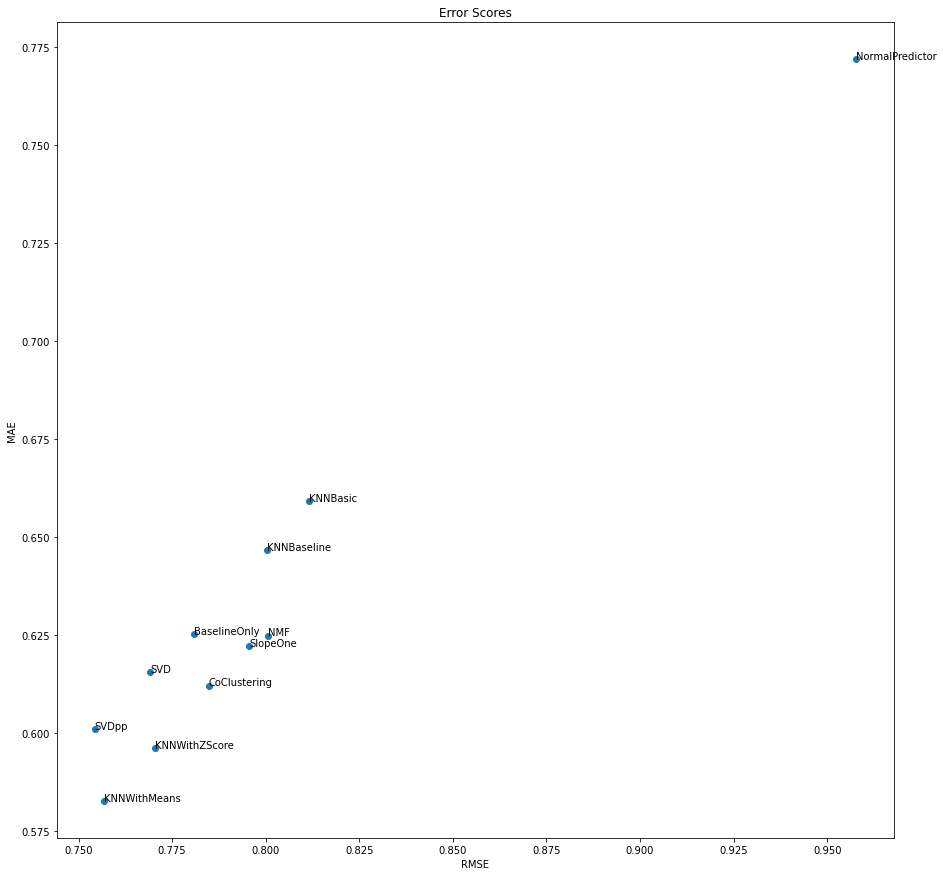

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

x = results['test_rmse']
y = results['test_mae']

_ = plt.scatter(x, y)
_ = plt.title('Error Scores')
_ = plt.xlabel('RMSE')
_ = plt.ylabel('MAE')

for i, txt in enumerate(results.index):
    ax.annotate(txt, (x[i], y[i]))

In [ ]:
#SVDpp
param_grid = {'n_factors': [25, 30, 35, 40, 100], 
              'n_epochs': [15, 20, 25], 
              'lr_all': [0.001, 0.003, 0.005, 0.008], 
              'reg_all': [0.08, 0.1, 0.15, 0.02]}

SVDpp_GS = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5)
SVDpp_GS.fit(data) 
SVDpp_GS.best_params['rmse']

{'lr_all': 0.008, 'n_epochs': 25, 'n_factors': 25, 'reg_all': 0.08}

In [ ]:
results = cross_validate(SVDpp(lr_all=.008, n_epochs=25, n_factors=30, reg_all=.08), data, measures=['RMSE', 'MAE'], cv=5)
results = pd.DataFrame.from_dict(results).mean(axis=0)
results

test_rmse    0.752472
test_mae     0.596331
fit_time     0.266329
test_time    0.006559
dtype: float64

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
alg = SVDpp(lr_all=.008, n_epochs=25, n_factors=30, reg_all=.08)
predictions = alg.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.7696


0.7696226281886578

In [ ]:
#SVD
param_grid = {'n_factors': [25, 30, 35, 40, 100], 
              'n_epochs': [15, 20, 25], 
              'lr_all': [0.001, 0.003, 0.005, 0.008], 
              'reg_all': [0.08, 0.1, 0.15, 0.02]}

SVD_GS = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
SVD_GS.fit(data)
SVD_GS.best_params['rmse']

{'lr_all': 0.008, 'n_epochs': 25, 'n_factors': 25, 'reg_all': 0.08}

In [ ]:
results = cross_validate(SVD(lr_all=.008, n_epochs=25, n_factors=25, reg_all=.02), data, measures=['RMSE', 'MAE'], cv=5)
results = pd.DataFrame.from_dict(results).mean(axis=0)
results

test_rmse    0.746341
test_mae     0.589533
fit_time     0.030410
test_time    0.002098
dtype: float64

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
alg = SVD(lr_all=.008, n_epochs=25, n_factors=25, reg_all=.02)
predictions = alg.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.7634


0.7633931818791544

In [ ]:
#KNN With Means
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60]}

knnwm_GS = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
knnwm_GS.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [ ]:
x = [15, 20, 25, 30, 40, 50, 60]
y1 = knnwm_GS.cv_results['mean_test_rmse']
y2 = knnwm_GS.cv_results['mean_test_mae']

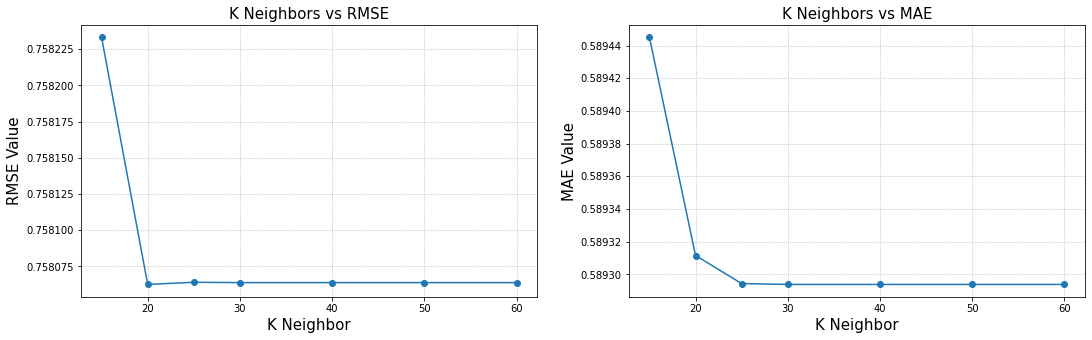

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.grid(ls='dotted')

plt.show()

In [ ]:
results = cross_validate(KNNWithMeans(k=25), data, measures=['RMSE', 'MAE'], cv=5)
results = pd.DataFrame.from_dict(results).mean(axis=0)
results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


test_rmse    0.756912
test_mae     0.585583
fit_time     0.004450
test_time    0.006441
dtype: float64

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
alg = KNNWithMeans(k=25)
predictions = alg.fit(trainset).test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7723


0.7722994237185457

In [ ]:
#SVD is the best predictor here

In [ ]:
#FIND SUGGESTIONS:

In [ ]:
svd = SVD_GS.best_estimator['rmse']
svd.fit(trainset)

In [ ]:
svd.qi.shape

(129, 25)

In [ ]:
svd.trainset._raw2inner_id_items

{132560: 116,
 132561: 117,
 132564: 109,
 132572: 104,
 132583: 101,
 132584: 108,
 132594: 18,
 132608: 54,
 132609: 69,
 132613: 119,
 132626: 84,
 132630: 29,
 132654: 57,
 132660: 35,
 132663: 125,
 132665: 83,
 132667: 100,
 132668: 75,
 132706: 113,
 132715: 46,
 132717: 124,
 132723: 26,
 132732: 41,
 132733: 58,
 132740: 63,
 132754: 25,
 132755: 31,
 132766: 95,
 132767: 5,
 132768: 93,
 132773: 106,
 132825: 20,
 132830: 10,
 132834: 15,
 132845: 102,
 132846: 123,
 132847: 99,
 132851: 50,
 132854: 66,
 132856: 37,
 132858: 68,
 132861: 59,
 132862: 12,
 132866: 81,
 132869: 97,
 132870: 107,
 132872: 92,
 132875: 70,
 132877: 126,
 132884: 94,
 132885: 21,
 132921: 17,
 132922: 77,
 132925: 74,
 132937: 114,
 132951: 1,
 132954: 78,
 132955: 48,
 132958: 13,
 134975: 115,
 134983: 61,
 134986: 27,
 134987: 118,
 134992: 112,
 134996: 90,
 134999: 56,
 135000: 82,
 135001: 67,
 135011: 128,
 135013: 91,
 135016: 96,
 135018: 121,
 135019: 86,
 135021: 24,
 135025: 42,
 1350

In [ ]:
def get_vector_by_restaurant(placeID):
  rest_name_idx = svd.trainset._raw2inner_id_items[placeID]
  return svd.qi[rest_name_idx]

In [ ]:
def cosine_distance(vector_a, vector_b):
  return cosine(vector_a, vector_b)

In [ ]:
restaurants[10:20]

,placeID,cuisine,rest_name,city,alcohol,smoking_area,dress_code,accessibility,price,ambience,franchise,parking_lot,payment
10,135086,Burgers,Mcdonalds Parque Tangamanga,San Luis Potosi,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,t,yes,MasterCard-Eurocard
11,135086,Fast_Food,Mcdonalds Parque Tangamanga,San Luis Potosi,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,t,yes,cash
12,135086,Fast_Food,Mcdonalds Parque Tangamanga,San Luis Potosi,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,t,yes,VISA
13,135086,Fast_Food,Mcdonalds Parque Tangamanga,San Luis Potosi,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,t,yes,MasterCard-Eurocard
14,135085,Fast_Food,Tortas Locas Hipocampo,San Luis Potosi,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,f,public,cash
15,135079,Chinese,Koye Sushi,San Luis Potosi,No_Alcohol_Served,none,informal,no_accessibility,high,familiar,f,none,cash
16,135079,Chinese,Koye Sushi,San Luis Potosi,No_Alcohol_Served,none,informal,no_accessibility,high,familiar,f,none,American_Express
17,135075,Seafood,Mariscos El Pescador,San Luis Potosi,No_Alcohol_Served,none,informal,no_accessibility,medium,familiar,f,yes,cash
18,135074,Contemporary,Restaurante la Parroquia Potosina,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,public,cash
19,135074,Contemporary,Restaurante la Parroquia Potosina,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,public,VISA


In [ ]:
restaurants[restaurants.price == 'high']

,placeID,cuisine,rest_name,city,alcohol,smoking_area,dress_code,accessibility,price,ambience,franchise,parking_lot,payment
15,135079,Chinese,Koye Sushi,San Luis Potosi,No_Alcohol_Served,none,informal,no_accessibility,high,familiar,f,none,cash
16,135079,Chinese,Koye Sushi,San Luis Potosi,No_Alcohol_Served,none,informal,no_accessibility,high,familiar,f,none,American_Express
18,135074,Contemporary,Restaurante la Parroquia Potosina,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,public,cash
19,135074,Contemporary,Restaurante la Parroquia Potosina,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,public,VISA
20,135074,Contemporary,Restaurante la Parroquia Potosina,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,public,MasterCard-Eurocard
21,135073,Bar,Restaurante Bar El Gallinero,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,yes,cash
22,135073,Bar,Restaurante Bar El Gallinero,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,yes,VISA
23,135073,Bar,Restaurante Bar El Gallinero,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,yes,MasterCard-Eurocard
24,135073,Bar_Pub_Brewery,Restaurante Bar El Gallinero,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,yes,cash
25,135073,Bar_Pub_Brewery,Restaurante Bar El Gallinero,San Luis Potosi,Wine-Beer,section,informal,no_accessibility,high,familiar,f,yes,VISA


In [ ]:
#Check restaurant similarity between La Cantina Restaurante, 135052, and McDonalds Parque Tangamanga, 135086
La_Cantina_vector = get_vector_by_restaurant(135052)
McDonalds_vector = get_vector_by_restaurant(135086)

In [ ]:
cosine_distance(La_Cantina_vector, McDonalds_vector)

0.9061731615499266

In [ ]:
#try with Restaurante Bar El Gallinero, 135073
Gallinero_vector = get_vector_by_restaurant(135073)

In [ ]:
cosine_distance(La_Cantina_vector, Gallinero_vector)

0.8815615218945083

In [ ]:
#the higher the number, the more different the items are based on ratings

In [ ]:
def display_sim(similarity_table):
    similarity_table = pd.DataFrame(
        similarity_table,
        columns=['rest_name', 'vector cosine distance']
    ).sort_values('vector cosine distance', ascending=True)
    return similarity_table.iloc[:5]

def get_top_similarities(placeID):
    rest_vector: np.array = get_vector_by_restaurant(placeID)
    similarity_table = []

    for other_rest in svd.trainset._raw2inner_id_items.keys():
        other_rest_vector = get_vector_by_restaurant(other_rest)
        
        # Get the second movie vector, and calculate distance
        similarity_score = cosine_distance(other_rest_vector, rest_vector)
        similarity_table.append((other_rest, similarity_score))
    
    # sort movies by ascending similarity
    return display_sim(sorted(similarity_table))

In [ ]:
def get_new_suggestions(user_id, model=svd):
    #find the users top 5 rated restaurants
    user_top_5_rated = list(ratings[ratings['userID']==user_id].sort_values('rating', ascending=False)['placeID'][:5])
    #put together a list of all the restaurants the user has rated
    rest_user_rated = list(ratings[ratings['userID']==user_id]['placeID'].unique())

    #pull the two most similar restaurants
    for item in user_top_5_rated:
        df = get_top_similarities(item)
        recs = list(df['rest_name'])

        recs_user_not_rated = [r for r in recs if r not in rest_user_rated]
                
    suggestions_df = restaurants[restaurants['placeID'].isin(recs_user_not_rated)][['placeID', 'rest_name', 'city', 'cuisine', 'price', 'ambience', 'alcohol']].reset_index().drop('index', axis=1).drop_duplicates()
            
    return suggestions_df

In [ ]:
users[users['userID']=='U1006']

,userID,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,age,interest,personality,religion,activity,weight,budget,height
22,U1006,True,social drinker,no preference,friends,car owner,single,independent,32,variety,hard-worker,none,student,165.3465,medium,5.905512


In [ ]:
get_new_suggestions('U1006', svd)

,placeID,rest_name,city,cuisine,price,ambience,alcohol
0,135059,Restaurant Bar Hacienda los Martinez,San Luis Potosi,Bar,medium,familiar,Wine-Beer
1,132706,Gorditas Dona Tota,Ciudad Victoria,Mexican,medium,familiar,No_Alcohol_Served
3,132608,Hamburguesas La perica,Ciudad Victoria,Mexican,low,quiet,No_Alcohol_Served


In [ ]:
#find similarities to a particular restaurant
restaurants[restaurants['placeID']==135079]

,placeID,cuisine,rest_name,city,alcohol,smoking_area,dress_code,accessibility,price,ambience,franchise,parking_lot,payment
15,135079,Chinese,Koye Sushi,San Luis Potosi,No_Alcohol_Served,none,informal,no_accessibility,high,familiar,f,none,cash
16,135079,Chinese,Koye Sushi,San Luis Potosi,No_Alcohol_Served,none,informal,no_accessibility,high,familiar,f,none,American_Express


In [ ]:
r_135079 = pd.DataFrame(get_top_similarities(135079))
r_135079

,rest_name,vector cosine distance
118,135079,0.000000
19,132715,0.490084
99,135054,0.510169
47,132875,0.552167
26,132755,0.630822


In [ ]:
r_135079 = r_135079['rest_name'].to_list()
r_135079

[135079, 132715, 135054, 132875, 132755]

In [ ]:
rec_135079 = restaurants[restaurants['placeID'].isin(r_135079)]
rec_135079 = rec_135079[['placeID', 'rest_name', 'city', 'cuisine', 'price', 'ambience', 'alcohol']].drop_duplicates(subset='placeID')
rec_135079 = rec_135079.drop(rec_135079.index[0])
rec_135079

,placeID,rest_name,city,cuisine,price,ambience,alcohol
53,135054,Restaurante y Pescaderia Tampico,San Luis Potosi,Seafood,high,familiar,No_Alcohol_Served
160,132875,shi ro ie,San Luis Potosi,Japanese,high,familiar,Wine-Beer
200,132755,La Estrella de Dimas,San Luis Potosi,Mexican,medium,familiar,No_Alcohol_Served
214,132715,tacos de la estacion,Ciudad Victoria,Mexican,low,quiet,No_Alcohol_Served
